In [ ]:
import logging
logging.getLogger("").setLevel("INFO")
import pandas as pd
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# on charge le fichier
fname = 'sondage_tuteursUVCI_reponses.xlsx'
df =  pd.read_excel(fname)

# cleaning de base
def naCols(df):
    """returns cols filled with nans"""
    # colls with nan
    L =  []
    for (i,c) in enumerate(df.columns):
        if all(df.loc[:,c].isna()):
            L.append(c)
    return L
# on enlève les colonnes pleine de nana
df = df.drop(labels=naCols(df), axis=1)

# on enlève les réponses qui sont biaisées car des tests de ma part
df = df.drop(df.loc[df.iloc[:,1] == 1].index)

# on crée un dictionnaire avec des raccourcis pour les colonnes
Q = lambda x: df.columns[x]
logging.debug(Q(1))
Qs = {'Q%02d'%i: Q(i) for i in range(len(df.columns))}
logging.debug(Qs)

In [ ]:
#### ON reformat le long label des colonnes ####
cols = df.columns
df.columns = (
    ["Horodateur", "On apprend mieux\nà plusieurs que seul",
     "Les NTIC permettent\nune meilleure collaboration entre les individus",
     "Les NTIC renforcent\nle sentiment d'isolement des individus",
     "Je sais facilement\nqui est connecté",
     "Je sais facilement\nqui répond à qui",
     "Lorsque je cherche un message,\nje le retrouve facilement",
     "Je suis satisfait\ndes outils de suivi existant\nou de ma façon de suivre\nle travail des apprenants en ligne",
     "Combien de temps en moyenne\npar semaine passez-vous actif,\nsur les tchats de vos groupes ?",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[hors-ligne]",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[avec Google hangout]",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[sur les forums de l'UVCI]",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[avec Facebook, ]",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[avec Whatsapp,]",
     "Pour travailler collectivement,\nvos étudiants échangent régulièrement\n[par Mail]",
     "Quels autres moyens de communication\nvos étudiants utilisent-ils\npour travailler ensemble ?",
     "Que pouvez-vous ajouter\nsur les  habitudes de travail\nde vos étudiants ?",
     "Voir le nombre total\nde messages publiés\nc'est",
     "Voir le nombre total\nde messages publiés pour chaque étudiants\nc'est",
     "Voir les messages publiés\npour une période donnée\nc'est",
     "Accéder facilement au contenu\ndes messages publiés à n'importe quel moment\nc'est",
     "Voir facilement si\nun message est une question\nc'est",
     "Voir facilement si\nun message est une réponse\nc'est",
     "Voir facilement si\nun message est hors-sujet\nc'est",
     "Voir le nombre d'étudiants connectés\ndepuis le début de la session\nc'est",
     "Voir le nombre d'étudiants connectés\nà un moment donné\nc'est",
     "Voir des statistiques sur\nles contenus des messages\nc'est",
     "Voir des statistiques sur\nles messages\nc'est",
     "Voir des statistiques sur\nles auteurs des messages c'est",
     "Finalement quoi d'autre,\nserait-il important de visualiser\npour améliorer le suivi de vos apprenants ?",
     "Quels sont les niveaux (semestres)\net spécialités de vos groupes d'étudiants?"])


In [ ]:
["Horodateur", "On apprend mieux\nà plusieurs que seul", "Les NTIC permettent\nune meilleure collaboration\nentre les individus", "Les NTIC renforcent\nle sentiment d'isolement des individus", "Je sais facilement qui\nest connecté", "Je sais facilement qui\nrépond à qui", "Lorsque je cherche un message,\nje le retrouve facilement", "Je suis satisfait\ndes outils de suivi existant\nou de ma façon de suivre\nle travail des apprenants en ligne"]

In [ ]:
# get col with values between 0 and 5
# on discrimine les colonnes
estCols = []  # questions en est ...
okCols = [] # questions d'accords (échelle de confidence)
tCols = [] # questions vraie ou faux
oCols = []  # autres colonnes (questions)

# les colonnes avec des réponses numériques
for c in df.columns:
    if (df.loc[:, c].dtype in [int or float]
        and df.loc[:, c].max() <= 5
        and df.loc[:, c].min() >= 0):
        if "c'est" in c:
            estCols.append(c)
        else:
            okCols.append(c)

            # les response en string            
strCols = set(df.columns) - set(estCols) - set(okCols)
for c in strCols:
    if 'Pour travailler' in c:
        tCols.append(c)
    else:
        oCols.append(c)

In [ ]:
######## On dessine les résultats plus manuellement ####
# values counts for each columns
def get_hist_df(df):
    """Given a df, renvois le value_counts pour chaque colonnes dans un df
    Les colonnes de df sont des questions\n
    Les lignes de df sont les réponses.\n
En sortie on a un hist_df avec l'image en index et les questions en colonnes et les cumul en valeurs"""

    # un dic pour chaque colonne on a une pd.Serie de value_counts() (ie. values and counts)
    D = {}
    for c in df:
        D[c] = df.loc[:,c].value_counts()
        
    hist_df = pd.DataFrame(D)
    return hist_df



In [ ]:
def plot_stacked_horizontal_bar_chart(df, labels, title, reverse=False, size=(13,8), strfmt="%3d%%", **args):
    """drawing the stack horizontal bar chart
    df is a value_count dataframe
    reverse=False, size=(13,8), strfmt=\"%3d%%\""""
    fig, ax = plt.subplots()
    # canvas = FigureCanvasAgg(fig)
    if reverse:
        df = df[::-1]
        labels = labels[::-1]

    for j in range(len(df)): 
        # pour catégorie on décale vers la droite pour faire un stackbarh
        if j > 0:
            arg = {'left': df.iloc[:j,:].sum()}
        else:
            arg = {'left': [0]*len(df.columns)}
            # on plot la catégorie sur le graphique
        plt.barh(df.columns, df.iloc[j].values, label=labels[j], **arg)


        # legend et other stuff
    ax.grid(axis='x')
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter(strfmt))
    # ax.legend(loc='best', shadow=True, edgecolor=None)
    ax.legend()
    ax.set_title(title)
    fig.set_size_inches(size)
    #    xaxis = plt.gca().xaxis
    fig.subplots_adjust(**args)
    return fig

In [ ]:
################ Graphiques ################

In [ ]:
# Graphe de la Satisfaction
hist_df = round(get_hist_df(df.loc[:,okCols]) / len(df) * 100, 2)


In [ ]:
labels= ["Pas d'accord du tout", "Pas d'accord", "Indécis", "Assez d'accord",  "Tout à fait d'accord"]
title = "% des tuteurs et leur avis concernant les NTICs, la collaboration et le suivi des étudiants"
plot_stacked_horizontal_bar_chart(hist_df, labels, title, reverse=True, size=(20,8), left=.5).savefig('satisfaction.png')

In [ ]:
hist_df.columns

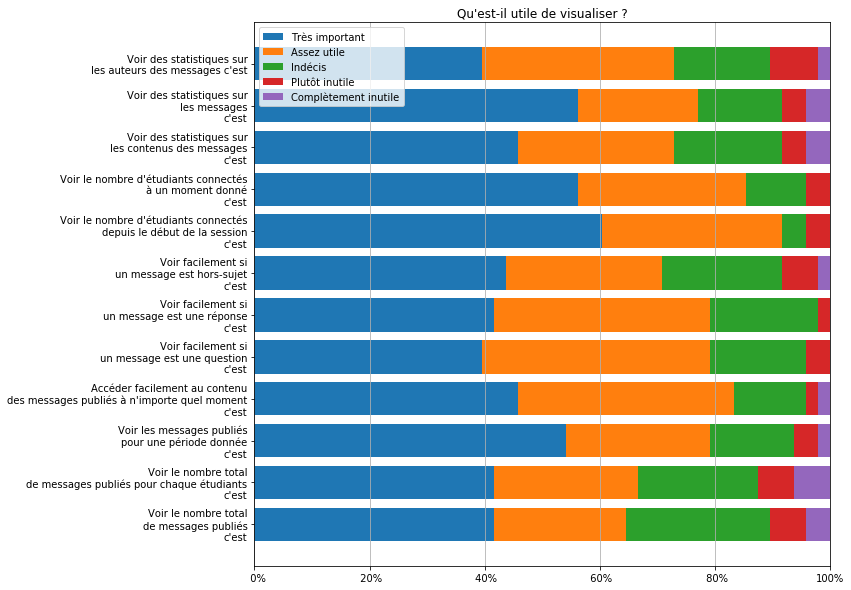

In [57]:
# Graphe de l'Utilité
hist_df = round(get_hist_df(df.loc[:,estCols]) / len(df) * 100, 2)
labels= ["Complètement inutile", "Plutôt inutile", "Indécis", "Assez utile", "Très important"]
title = "Qu'est-il utile de visualiser ?"

plot_stacked_horizontal_bar_chart(hist_df, labels, title, reverse=True, size=(20,10), left=.5).savefig('utilite.png')

In [ ]:
################ reparation REP  ################
################ fin zone reparation  ####